## Loading packages and definitions

In [1]:
import numpy as np
import pickle
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
import itertools
import math
from utils import *

Defining some relationships

In [2]:
B = 25 #MC repetitions
correlation = 'pearson' #meta-metric

dims = ['coh', 'con', 'flu', 'rel']

dims2datasets = {'coh': ['summeval', 'newsroom'],
                 'con': ['summeval', 'newsroom', 'hallxsum', 'qagscnn', 'qagsxsum'],
                 'flu': ['summeval', 'newsroom'],
                 'rel': ['summeval', 'newsroom']}

datasets2dims = {'summeval': ['coh', 'con', 'flu', 'rel'],
                 'newsroom': ['coh', 'con', 'flu', 'rel'],
                 'hallxsum': ['con'],
                 'qagscnn': ['con'],
                 'qagsxsum': ['con']}

datasets2label = {'summeval': 0,
                  'newsroom': 1,
                  'qagscnn': 2,
                  'hallxsum': 3,
                  'qagsxsum': 4}

label2datasets = {0:'summeval',
                  1:'newsroom',
                  2:'qagscnn',
                  3:'hallxsum',
                  4:'qagsxsum'}

dims2datasetslabels = {'coh': [datasets2label['summeval'], datasets2label['newsroom']], 
                       'con': [datasets2label['summeval'], datasets2label['newsroom'], datasets2label['hallxsum'], datasets2label['qagscnn'], datasets2label['qagsxsum']],
                       'flu': [datasets2label['summeval'], datasets2label['newsroom']],
                       'rel': [datasets2label['summeval'], datasets2label['newsroom']]}

## Setting up data

Loading data

In [3]:
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)

Some definitions

In [4]:
datasets = list(data.keys())
metrics_names = list(data['summeval']['metrics'].keys())

datasets, metrics_names

(['summeval', 'newsroom', 'qagscnn', 'qagsxsum', 'hallxsum'],
 ['bertscorefree',
  'bartcnnscore',
  'bartscore_pegasus_cnndm',
  'bartscore_pegasus_newsroom',
  'bartscore_pegasus_xsum',
  'unieval'])

Renaming dimensions

In [5]:
key_mapping = {"rel": "con", "info": "rel"}
for old_key, new_key in key_mapping.items():
    if old_key in data['newsroom']['annot']:
        data['newsroom']['annot'][new_key] = data['newsroom']['annot'].pop(old_key)

for dataset in ['qagscnn', 'qagsxsum', 'hallxsum']:
    key_mapping = {"fact": "con"}
    for old_key, new_key in key_mapping.items():
        if old_key in data[dataset]['annot']:
            data[dataset]['annot'][new_key] = data[dataset]['annot'].pop(old_key)

Organizing data for model training

In [6]:
for dataset in datasets:
    ##### Y #####
    for dim in data[dataset]['annot'].keys():
        data[dataset]['annot'][dim] = np.array(data[dataset]['annot'][dim])
        
    ##### X #####
    data[dataset]['metrics']['array'] = []
    data[dataset]['metrics']['names'] = []

    for metric in metrics_names:
        metric_array = np.array(data[dataset]['metrics'][metric])
        metric_array = metric_array.reshape(metric_array.shape[0], -1)
            
        if metric=='unieval':
            data[dataset]['metrics']['array'] += np.array(metric_array[:,:3].tolist()).T.tolist()
            data[dataset]['metrics']['names'] += 3*[metric]
        else:   
            data[dataset]['metrics']['array'] += np.array(metric_array.tolist()).T.tolist()
            data[dataset]['metrics']['names'] += metric_array.shape[1]*[metric]
    
    data[dataset]['metrics']['array'] = np.array(data[dataset]['metrics']['array']).T

Data sizes

In [7]:
# Training set sizes
m = {}
m['summeval'] = 370
m['newsroom'] = 370
m['hallxsum'] = 370
m['qagsxsum'] = 180
m['qagscnn'] = 180

# Test set sizes
n = {}
n['summeval'] = 50
n['newsroom'] = 50
n['hallxsum'] = 50
n['qagsxsum'] = 50
n['qagscnn'] = 50

## Running exp

Standardizing response variables 

In [8]:
for dataset in datasets: 
    for dim in datasets2dims[dataset]:
        array = np.array(data[dataset]['annot'][dim])
        data[dataset]['annot'][dim] = (array-array.mean())/array.std()

Creating data structures to store results

In [9]:
results = {}
for dataset in datasets:
    for dim in datasets2dims[dataset]: 
        task = dataset+"_"+dim
        results[task] = {}
        for split in ['train','test']:
            results[task][split] = {}
            results[task][split]['annots'] = []
            for metric in dims2datasets[dim] + metrics_names:
                results[task][split][metric] = []

#We will store experts used in each data point for each task
exp_ind = {}

#These X and y will be used to classify a text according to membership
X = {}
y = {}
for split in ['train','test']:
    X[split] = []
    y[split] = []

#We will store classifiers here
classifiers = []

Running experiment

In [10]:
### Monte Carlo ###
for b in tqdm(range(B)): 
    
    ### Spliting data indices ###
    random.seed(b)
    indices = {}
    indices['train'] = {}
    indices['test'] = {}
    
    for dataset in datasets:
        ind = random.sample(list(range(data[dataset]['annot']['con'].shape[0])), m[dataset]+n[dataset]) #Sampling a total of m+n datapoints and then split them
        indices['train'][dataset] = ind[:m[dataset]] #Train indices
        indices['test'][dataset] = ind[m[dataset]:] #Test indices
    
    ### Training experts ###
    experts = {}
    for dim in dims:
        experts[dim] = {}
        for dataset in dims2datasets[dim]:
            experts[dim][dataset] = LinearRegression(positive=True)
            experts[dim][dataset].fit(data[dataset]['metrics']['array'][indices['train'][dataset]], data[dataset]['annot'][dim][indices['train'][dataset]])
        
        
    ### Using experts and benchmarks to predict scores ### 
    for dim in dims:
        for dataset in dims2datasets[dim]:
            
            task = dataset+"_"+dim
            
            # We need to store separately train and test results because we can only train membership classifier using training set #
            for split in ['train','test']:
                
                # Storing annots #
                results[task][split]['annots'].append(data[dataset]['annot'][dim][indices[split][dataset]])

                # Computing and storing auto metrics #
                for metric in dims2datasets[dim] + metrics_names:

                    if metric in dims2datasets[dim]:
                        y_hat = experts[dim][metric].predict(data[dataset]['metrics']['array'][indices[split][dataset]])

                    elif metric=='bertscorefree':
                        y_hat = np.array(data[dataset]['metrics']['bertscorefree'])[indices[split][dataset], 0] #precision (best) score
                                        
                    elif metric=='unieval':
                        if dim=='coh':
                            y_hat = np.array(data[dataset]['metrics']['unieval'])[indices[split][dataset], 0]
                        elif dim=='con':
                            y_hat = np.array(data[dataset]['metrics']['unieval'])[indices[split][dataset], 1]
                        elif dim=='flu':
                            y_hat = np.array(data[dataset]['metrics']['unieval'])[indices[split][dataset], 2]
                        else:
                            y_hat = np.array(data[dataset]['metrics']['unieval'])[indices[split][dataset], 3]

                    else:
                        y_hat = np.array(data[dataset]['metrics'][metric])[indices[split][dataset]]

                    
                    results[task][split][metric].append(y_hat) 
    
    ### Obtaining X and y for membership classification ###
    for split in ['train','test']:
        X[split].append(np.hstack([[experts[dim][expert].predict(data[dataset]['metrics']['array'][indices[split][dataset]]) for dim in dims for expert in dims2datasets[dim]] for dataset in datasets]).T)
    y['train'].append(np.hstack([m[dataset]*[datasets2label[dataset]] for dataset in datasets]))
    y['test'].append(np.hstack([n[dataset]*[datasets2label[dataset]] for dataset in datasets]))

    ### Training classifiers ###
    classifiers.append(catb(X['train'][-1], y['train'][-1], test_size=0.1, balance=True)) #Since test set is balanced, we will balance the training set
    
    ### Getting predicted membership for modelfuser evaluation ###
    exp_ind[b] = {}
    for dim in dims:
        
        for dataset in dims2datasets[dim]:
            task = dataset+"_"+dim
            possible_classes = dims2datasetslabels[dim]
            proba = classifiers[-1].predict_proba(np.hstack([[experts[dim][expert].predict(data[dataset]['metrics']['array'][indices['test'][dataset]]) for dim in dims for expert in dims2datasets[dim]]]).T)         
            experts_indices = np.array([possible_classes[x] for x in np.argmax(proba[:, possible_classes], axis=1)])
            exp_ind[b][task] = experts_indices

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:22<00:00,  8.10s/it]


Checking confusion matrix

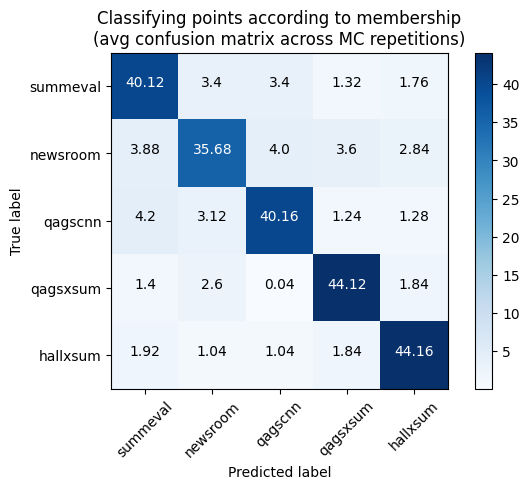

In [11]:
b=0
y_true = y['test'][b]
y_pred = classifiers[b].predict(X['test'][b])
cm = confusion_matrix(y_true, y_pred)
for b in range(1, B):
    y_true = y['test'][b]
    y_pred = classifiers[b].predict(X['test'][b])
    cm += confusion_matrix(y_true, y_pred)
cm=cm/B

plot_confusion_matrix(cm, classes=datasets, title='Classifying points according to membership\n(avg confusion matrix across MC repetitions)')
plt.savefig('plots/confusion_matrix.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Avg correlation (across experts)

In [12]:
scores = {}

for b in range(B):
    scores[b] = {}
    
    for dim in dims:

        for dataset in dims2datasets[dim]:
            task = dataset+"_"+dim
            metrics = list(results[task]['test'].keys())
            metrics.remove('annots')
            scores[b][task] = {}

            for metric in metrics: 
                scores[b][task][metric] = calculate_correlation(results[task]['test']['annots'][b], results[task]['test'][metric][b], correlation)
                scores[b][task][metric] = np.nan_to_num(scores[b][task][metric])
                
            scores[b][task]['modelfuser'] = np.array([scores[b][task][dataset2] for dataset2 in dims2datasets[dim]])@np.array([np.mean(np.array(exp_ind[b][task])==label) for label in dims2datasetslabels[dim]])
            scores[b][task]['oracle'] = scores[b][task][dataset]

In [13]:
# a waring will appear cause we are taling avgs and std of empty arrays in the third line of inner loop (there is no eval for coh,flu,rel when metric==qags's or xsum)
tasks=[]
for dim in dims:
    for dataset in dims2datasets[dim]:
        tasks.append(dataset+"_"+dim)
        
for b in range(B):
    scores[b]['avg'] = {}
    scores[b]['avg_con'] = {}
    scores[b]['avg_no_con'] = {}
    
    for metric in ['oracle','modelfuser'] + datasets + metrics_names:
        scores[b]['avg'][metric] = np.mean([scores[b][key][metric] for key in tasks if metric in scores[b][key].keys()])
        scores[b]['avg_con'][metric] = np.mean([scores[b][key][metric] for key in tasks if key[-3:]=='con'])
        scores[b]['avg_no_con'][metric] = np.mean([scores[b][key][metric] for key in tasks if metric in scores[b][key].keys() and key[-3:]!='con'])     

/home/skunk/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/skunk/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
scores_agg = {}

for key in scores[0].keys():
    scores_agg[key] = {}
    
    for metric in ['oracle','modelfuser'] + datasets + metrics_names:
        arr = [scores[b][key][metric] for b in range(B) if metric in scores[b][key].keys()]
        scores_agg[key][metric] = {}
        scores_agg[key][metric]['avg'] = np.round(np.mean(arr), 3)
        scores_agg[key][metric]['std'] = np.round(np.std(arr), 3)

/home/skunk/.local/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/skunk/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/skunk/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
dic = scores_agg

for key in dic:
    line = key
    for subkey in dic[key]:
        avg = dic[key][subkey]['avg']
        if math.isnan(avg):
            line += " & -"
        else:
            line += " & " + str(avg)
    line += " \\\\"
    print(line)

summeval_coh & 0.61 & 0.599 & 0.61 & 0.525 & - & - & - & 0.423 & 0.448 & 0.428 & 0.463 & 0.371 & 0.489 \\
newsroom_coh & 0.653 & 0.649 & 0.627 & 0.653 & - & - & - & 0.604 & 0.643 & 0.621 & 0.543 & 0.601 & 0.435 \\
summeval_con & 0.655 & 0.613 & 0.655 & 0.293 & 0.502 & 0.548 & 0.499 & 0.436 & 0.237 & 0.314 & 0.356 & 0.189 & 0.646 \\
newsroom_con & 0.685 & 0.652 & 0.51 & 0.685 & 0.612 & 0.592 & 0.586 & 0.615 & 0.657 & 0.634 & 0.529 & 0.589 & 0.41 \\
hallxsum_con & 0.243 & 0.237 & 0.209 & 0.167 & 0.237 & 0.241 & 0.243 & 0.191 & 0.202 & 0.203 & 0.202 & 0.216 & 0.182 \\
qagscnn_con & 0.747 & 0.738 & 0.716 & 0.673 & 0.747 & 0.747 & 0.729 & 0.627 & 0.728 & 0.737 & 0.724 & 0.598 & 0.642 \\
qagsxsum_con & 0.348 & 0.343 & 0.357 & 0.112 & 0.337 & 0.348 & 0.323 & 0.1 & 0.232 & 0.196 & 0.196 & 0.086 & 0.34 \\
summeval_flu & 0.594 & 0.578 & 0.594 & 0.459 & - & - & - & 0.339 & 0.225 & 0.281 & 0.303 & 0.155 & 0.461 \\
newsroom_flu & 0.61 & 0.599 & 0.525 & 0.61 & - & - & - & 0.553 & 0.597 & 0.579 & 0.5

In [16]:
for key in ['avg', 'avg_con', 'avg_no_con']:

    metric1 = 'modelfuser'
    arr1 = np.array([scores[b][key][metric1] for b in range(B)])
    
    metric2 = 'summeval'
    arr2 = np.array([scores[b][key][metric2] for b in range(B)])
    
    print(key , np.round(np.mean(arr1-arr2),3), np.round(np.std(arr1-arr2),3))

avg 0.024 0.013
avg_con 0.027 0.02
avg_no_con 0.021 0.013
